# Analysing Dataset

In [1]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

This notebook is dedicated to datasets analysis. 

Here we will concentrate on connecting our datasets into one dataframe that will later be used to extract meaningful information that can help us answer our research questions. 

In addition, data cleaning is performed where necessary since we will not use all the data provided. The goal of this notebook is to make data as easy as possible to use for future plotting and data story writing.

So, let's dive into our data!

In [2]:
import os
import re
import json
import time
import datetime
from functools import reduce
from itertools import product

from json import load, JSONDecodeError
from functional import pseq, seq
import pandas as pd
import pandas_profiling
import requests
import pathlib

# necessary to load the utils, which are in src
import sys
sys.path.append('../src')

from utils import file, logging
from utils.statement_handling import extract_information, safe_json_read

from importlib import reload

import utils.statement_handling as SH
reload(SH)

<module 'utils.statement_handling' from '../src/utils/statement_handling.py'>

In [3]:
def group_and_count(df, groupby_column, with_pct=False, with_avg=False):
    result = df.groupby(groupby_column).size().sort_values(ascending=False).reset_index().rename(columns={0: 'count'})
    if with_pct:
        result['count_pct'] = result['count'] / result['count'].sum()
    if with_avg:
        result['count_avg'] = result['count'].mean()
    return result

In [4]:
directory_liar_dataset = "../data/liar_dataset"
directory_statements = f"{directory_liar_dataset}/statements"
directory_visualizations = "../docs/data_insight"
directory_election_results = "../data/election_results"
directory_county_data = "../data/county_data"

# LIAR Dataset

This is just the LIAR dataset:

In [86]:
statements = seq(pathlib.Path(directory_statements).iterdir()).map(safe_json_read)\
                               .filter(lambda x: len(x) > 0)\
                               .map(extract_information)\
                               .to_pandas()

statements['statement_date'] = pd.to_datetime(statements['statement_date'])
statements.sample(10)

ERROR:root:File ../data/liar_dataset/statements/5355.json is empty or something...
ERROR:root:File ../data/liar_dataset/statements/9.json is empty or something...


,author_name_slug,context,label,ruling_date,speaker_current_job,speaker_first_name,speaker_home_state,speaker_last_name,statement,statement_date,statement_id,statement_type,statement_type_description
13566,wes-allison,"a debate in Orlando, Fla.",barely-true,2007-10-22T00:00:00,Attorney,Rudy,New York,Giuliani,I brought down crime more than anyone in this country -- maybe in the history of this country -- while I was mayor of New York City. -,2007-10-21,42,Claim,blog post
2280,robert-farley,"Associated Press Annual Meeting, Washington D.C.",false,2008-04-16T00:00:00,President,Barack,Illinois,Obama,Hes promising four more years of an administration that will push for the privatization of Social Security...,2008-04-14,437,Attack,<p>\r\n\tA criticism of a candidate.</p>\r\n
10810,janie-har,a news story,true,2012-09-13T17:06:41,,Bill,,Kennemer,"We just don&#39;t want to get to be like Louisiana, where you have drive-up daiquiri shops.",2012-09-11,6707,Claim,blog post
6065,c-eugene-emery,"an episode of ""Full Frontal with Samantha Bee""",half-true,2016-05-17T16:30:03,"President, National Abortion Federation",Vicki,,Saporta,There are more than twice as many (crisis pregnancy centers) as there are legitimate abortion providers in the United States.,2016-05-09,12388,Claim,blog post
5217,w-gardner-selby,a commentary,true,2014-06-05T14:21:11,Editorial writer,Mike,Texas,Hashimoto,Public display of a long rifle is perfectly legal in Texas.,2014-06-02,9412,Claim,blog post
12187,lauren-carroll,a campaign rally in Iowa,half-true,2016-02-10T16:00:00,President,Donald,New York,Trump,I&#39;m self-funding my own campaign.,2016-02-01,11889,Claim,blog post
6010,tom-humphrey,House floor debate over amending the state constitution to prohibit an income tax.,false,2012-02-09T04:30:00,House Majority Leader,Gerald,Tennessee,McCormick,<div style=background-color: transparent; ><b id=internal-source-marker_0.8907879865728319 style=font-weight: normal; >The state constitution clearly says there&rsquo;s not to be a state income tax in Tennessee.</b></div>,2012-01-19,5324,Claim,blog post
10862,alex-kuffner,a rally.,half-true,2012-04-01T06:00:00,restaurateur,John,Rhode Island,Elkhay,"If Rhode Island raises the meal and beverage tax to 10 percent, it would be the fourth-highest in the nation.",2012-03-21,5652,Claim,blog post
7430,w-gardner-selby,an op-ed column.,mostly-true,2011-02-02T06:00:00,Small business owner,Mike,Texas,Villarreal,"Says that over the last decade, the state&#39;s population grew three times faster than the Texas state tax system.",2011-01-07,3157,Claim,blog post
2872,lauren-carroll,a rally in Cincinnati,true,2016-11-01T16:07:03,Presidential candidate,Hillary,New York,Clinton,"Says of Donald Trump, He even said, on his very first day in office, he would require every school in America to let people carry guns into our classrooms.",2016-10-31,13395,Claim,blog post


In [150]:
statements['speaker_last_name'].eq('Trump').sum()

646

In [7]:
print('The number of different context names is: {}.\
 That is much too many different contexts and lots of them appear only a few times.\
 We thus need to regroup/reduce the number of contexts.'.format(group_and_count(statements, 'context').shape[0]))

The number of different context names is: 5828. That is much too many different contexts and lots of them appear only a few times. We thus need to regroup/reduce the number of contexts.


In [8]:
group_and_count(statements, 'context').head(100)

,context,count
0,a tweet,471
1,an interview,380
2,a news release,329
3,a press release,325
4,a speech,319
5,a TV ad,275
6,a campaign ad,221
7,a headline,175
8,a television ad,168
9,,166


So how to regroup all these or part of these?
We can use the mean of communication for example:
radio/tv/facebook/twitter/internet
and these classes can have overlap...

In [9]:
statements['clean_context'] = statements['context'].apply(SH.clean_up_context)

# ----------------------------------------------------------------------------------------------------
# Biggest liars pants on fire

Here are the people who most lie ordered by their proportion of pants on fire.

In [232]:
people_pants_classification = statements[['speaker_first_name', 'speaker_last_name', 'label']]

# Does not work : people_pants_classification = people_pants_classification.loc[people_pants_classification['speaker_first_name']!='' & people_pants_classification['speaker_first_name'].notnull()]
# So I did the following:
people_pants_classification = people_pants_classification.loc[people_pants_classification['speaker_first_name']!='']
people_pants_classification = people_pants_classification.loc[people_pants_classification['speaker_last_name']!='']
people_pants_classification = people_pants_classification.loc[people_pants_classification['speaker_first_name'].notnull()]
people_pants_classification = people_pants_classification.loc[people_pants_classification['speaker_last_name'].notnull()]

_blop = people_pants_classification[['speaker_first_name', 'speaker_last_name']].groupby(['speaker_first_name', 'speaker_last_name']).size().reset_index()
_blopblop = people_pants_classification.groupby(['speaker_first_name', 'speaker_last_name', 'label']).size().reset_index().rename(columns={'0':'nb_labeled_statements'})

statement_percentage = pd.merge(_blopblop,_blop,on=['speaker_first_name','speaker_last_name'])

statement_percentage['statements_perc'] = statement_percentage['0_x']/statement_percentage['0_y']
#statement_percentage.sample(5)

,speaker_first_name,speaker_last_name,label,0_x,0_y,statements_perc
3897,Mike,Rogers,true,1,7,0.142857
1445,Doug,Jones,mostly-true,1,3,0.333333
4623,Ron,Ramsey,pants-fire,1,3,0.333333
5537,Wayne,Rogers,pants-fire,1,1,1.000000
4894,Sheila,Oliver,mostly-true,3,6,0.500000


In [250]:
# pants on fire analysis
statement_percentage.loc[statement_percentage['label']=='pants-fire'].sort_values(by='statements_perc', ascending=False)
# remove all the statements_perc = 1 because they represent only pants-fire statements
statement_percentage_cleaned = statement_percentage.loc[statement_percentage['statements_perc']<1]
statement_percentage_cleaned.sample(5)

,speaker_first_name,speaker_last_name,label,0_x,0_y,statements_perc
5311,Todd,Staples,half-flip,1,12,0.083333
1228,David,Perdue,mostly-true,8,20,0.400000
1146,Dave,Aronberg,true,2,4,0.500000
4286,Ralph,Nader,false,1,4,0.250000
2245,Jeff,Brandes,true,2,4,0.500000


In [258]:
%matplotlib inline
#statement_percentage_cleaned.plot(kind='scatter' y='statements_perc')
import seaborn as sns

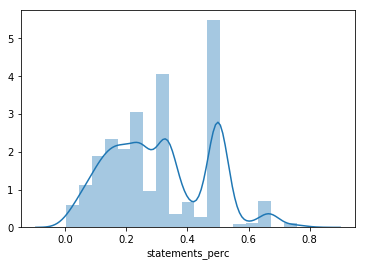

In [259]:
sns.distplot(statement_percentage_cleaned.statements_perc)

In [224]:
# Column renaming does not work
#.rename(columns={'0':'nb_statements'})
# to rename the column of counts df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
# _blop.rename(columns='0':'nb_statements')

In [225]:
# Verification, not needed
_blop[_blop['speaker_last_name'].eq('Trump')]

,speaker_first_name,speaker_last_name,0
783,Donald,Trump,639
1124,Ivanka,Trump,7


# ------------------------------------------------------------------------------------------------------

In [10]:
# no longer necessary
if false:
    df['label_as_nb'] = df['label'].apply(label_to_nb) * 2 
    df['statement_id'] = pd.to_numeric(df['statement_id'])
    lies = df.merge(additional_information, on='statement_id', how='left')

NameError: name 'false' is not defined

Let's just see what we have here:

In [11]:
# TODO rene add new values, see trello board
lies['label_to_nb'] = lies['label'].apply(label_to_nb) * 2

NameError: name 'lies' is not defined

In [12]:
lies['label'].value_counts()

NameError: name 'lies' is not defined

In [13]:
def _count_for_last_name_(df, last_name):
    return group_and_count(lies.loc[lies['speaker_last_name'].str.contains(last_name, flags=re.IGNORECASE), :], 'label', with_pct=True)\
            .rename(columns={'count': f'count_{last_name}', 'count_pct': f'count_pct{last_name}'})

In [14]:
pd.merge(_count_for_last_name_(lies, 'obama'), _count_for_last_name_(lies, 'trump'), on='label')

NameError: name 'lies' is not defined

Here we can see that Barack Obama had 549 statements labeled with _pants on fire_.

In [15]:
lies[lies['speakers_job_title'].str.contains('County') == True].shape

NameError: name 'lies' is not defined

In [16]:
lies['statement_date'].describe()

NameError: name 'lies' is not defined

Above, we can see that statements range from 1995 to 2016.

Now, let's do some profiling to get some more insights:

In [17]:
pandas_profiling.ProfileReport(lies)

NameError: name 'lies' is not defined

# Federal Election Results

We have another dataset that we will explore and merge to our LIAR dataset in order to get some more insight into data. This one is regarding election results.

In [18]:
pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 300

In [19]:
from itertools import product
from functools import reduce

In [20]:
def add_ending(f):
    """ File ending depending on a year
    
    Parameters
    ----------
    f: str
        Name of the file
    
    ToDos:
    - do 2012 it's a special snowflake
    """
    if '2016' in f:
        return f"{f}x"
    else:
        return f


election_files = [(add_ending(f'{directory_election_results}/federalelections{year}.xls'), year) for year in [2014, 2016]]

Now, let's prepare some data for viewing:

In [21]:
election_results_cols_of_interest = ['CANDIDATE NAME', 'PRIMARY VOTES', 'PRIMARY %']

def fix_columns_election_results(df, year, type_):
    """we are only interested in the primary votes, since these reflect the opinion the most"""
    df = df.loc[:, election_results_cols_of_interest]
    df[f'primary_votes_{type_.lower()}_{year}'] = df['PRIMARY VOTES']
    df[f'primary_votes_{type_.lower()}_{year}_pct'] = df['PRIMARY %']
    return df.drop(columns=['PRIMARY VOTES', 'PRIMARY %'])


def get_only_voting_results(df):
    return df.loc[df['CANDIDATE NAME'].notna() & df['PRIMARY VOTES'].notna() & df['CANDIDATE NAME'].ne('Scattered') & df['CANDIDATE NAME'].ne('All Others'), :]


def prep_election_results(df, year, type_):
    return fix_columns_election_results(get_only_voting_results(df), year, type_)

In [22]:
election_results = [prep_election_results(pd.read_excel(f, sheet_name=f'{year} US {type_} Results by State'), year, type_) for (f, year), type_ in product(election_files, ['Senate', 'House'])]

# we let the results as they are, merge, and then check if the person is a senator or a member of the house based on the other results
# yes they did a spelling mistake
election_results += [prep_election_results(pd.read_excel(f'{directory_election_results}/federalelections2012.xls', sheet_name=f'2012 US House & Senate Resuts'), 2012, 'all')]
election_results = reduce(lambda acc, el: pd.merge(acc, el, on='CANDIDATE NAME', how='outer'), election_results)

In [23]:
election_results.head()

,CANDIDATE NAME,primary_votes_senate_2014,primary_votes_senate_2014_pct,primary_votes_house_2014,primary_votes_house_2014_pct,primary_votes_senate_2016,primary_votes_senate_2016_pct,primary_votes_house_2016,primary_votes_house_2016_pct,primary_votes_all_2012,primary_votes_all_2012_pct
0,"Sessions, Jeff",Unopposed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Sullivan, Dan",44740,0.400548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Miller, Joe",35904,0.321441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Treadwell, Mead",27807,0.248950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Jaramillo, John M.",3246,0.029061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
idx_multiple_election_results = election_results.loc[:, [c for c in election_results.columns if any((c.endswith(str(y)) for y in [2012, 2014, 2016]))]].notna().sum(axis=1) > 1

print(f"we have multple election results for {idx_multiple_election_results.sum()} politicians ({idx_multiple_election_results.mean()}%)")

we have multple election results for 1110 politicians (0.19618239660657477%)


In [25]:
election_results[idx_multiple_election_results].head()

,CANDIDATE NAME,primary_votes_senate_2014,primary_votes_senate_2014_pct,primary_votes_house_2014,primary_votes_house_2014_pct,primary_votes_senate_2016,primary_votes_senate_2016_pct,primary_votes_house_2016,primary_votes_house_2016_pct,primary_votes_all_2012,primary_votes_all_2012_pct
16,"Gardner, Cory",338324,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,49340,1
19,"Wade, Kevin",18181,0.756627,NaN,NaN,NaN,NaN,NaN,NaN,Unopposed,NaN
32,"Schatz, Brian",115445,0.493460,NaN,NaN,162905,0.861662,NaN,NaN,NaN,NaN
33,"Hanabusa, Colleen Wakako",113663,0.485843,NaN,NaN,NaN,NaN,74022,0.803757,NaN,NaN
36,"Roco, John P.",4425,0.123572,NaN,NaN,3956,0.110303,NaN,NaN,545,0.0112848


In [26]:
# yeah ... let's see how many we can join. the one letter endings might be a problem
election_results['CANDIDATE NAME'].value_counts()

Tonko, Paul D.             36
Reed, Thomas W., II        36
Collins, Chris             24
Crowley, Joseph            12
Slaughter, Louise M.       12
Engel, Eliot L.            12
Nadler, Jerrold L.         12
Katko, John M.             12
Higgins, Brian             12
Maloney, Sean Patrick      12
Lowey, Nita M.             12
Israel, Steve J.            9
Gibson, Christopher P.      9
King, Peter T.              9
Maloney, Carolyn B.         8
Jeffries, Hakeem S.         8
Stefanik, Elise M.          8
Assini, Mark W.             8
Clarke, Yvette D.           8
Kuster, Ann McLane          8
Long, Wendy                 6
Bishop, Timothy H.          6
Hayworth, Nan               6
Zeldin, Lee M.              6
Grimm, Michael G.           6
Donovan, Dan                4
Turek, Jessica L.           4
Shea-Porter, Carol          4
Terry, Lee                  4
Gregory, Du Wayne           4
                           ..
Johnson, Bert               1
Hope, Stephen G.            1
Garrard, R

In [27]:
# we are only interest in people and they have a first name
lies = lies.loc[lies['speaker_first_name'].notnull(), :]

NameError: name 'lies' is not defined

In [28]:
# to aggregate the statements
lies['statement_year'] = lies['statement_date'].dt.year

# for the merging
lies['speaker_full_name'] = lies['speaker_last_name'] + ', ' + lies['speaker_first_name']

NameError: name 'lies' is not defined

### Cleaning job titles

In [29]:
# todo expand this and check this! this is just a quick and dirty fix
# is it really houseman? probably not...
_job_titles_of_interest = [('senat', 'senator'), ('governor', None), ('congress', 'congressman'), ('mayor', None), ('president', None), ('house', 'houseman'), ('rep', 'houseman')]
job_titles_of_interest = [out if out is not None else j for j, out in _job_titles_of_interest]

def cleaned_job_title(jt):
    jt = str(jt).lower()
    
    for j, out in _job_titles_of_interest:
        if j in jt:
            return out if out is not None else j
    else:
        return jt

lies['speakers_job_title_cleaned'] = lies['speakers_job_title'].apply(cleaned_job_title)

NameError: name 'lies' is not defined

In [30]:
_t = lies.merge(election_results, left_on='speaker_full_name', right_on='CANDIDATE NAME', how='outer')

NameError: name 'lies' is not defined

In [31]:
print(f"found election results for {_t['CANDIDATE NAME'].notnull().sum()} ({_t['CANDIDATE NAME'].notnull().mean()}%) people")

NameError: name '_t' is not defined

In [32]:
votes_cols = [c for c in _t.columns if 'votes' in c]
useful_idx = reduce(lambda acc, el: acc | el, [_t[c].notnull() for c in votes_cols]) & _t['speaker'].notnull() 

print(f"found useful results for {useful_idx.sum()} people")

columns_of_interest = ['label', 'label_as_nb', 'subject', 'speaker', 'speakers_job_title_cleaned', 'state_info', 'party_affiliation', 'context', 'statement_date'] + votes_cols
_t.loc[useful_idx, columns_of_interest]

NameError: name '_t' is not defined

In [33]:
_t.loc[useful_idx, 'speakers_job_title_cleaned'].value_counts()

NameError: name '_t' is not defined

In [34]:
_t.loc[_t['speakers_job_title_cleaned'].isin(job_titles_of_interest) & useful_idx, columns_of_interest]

NameError: name '_t' is not defined

Now, our dataframe looks like this:

In [35]:
_t.head(1)

NameError: name '_t' is not defined

# County Data

In [36]:
# load data file
county_raw = pd.read_csv(f"{directory_county_data}/acs2015_county_data.csv")
US_states = county_raw['State'].unique()
county_raw.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,51281.0,2391.0,24974,1080,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,50254.0,1263.0,27317,711,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,32964.0,2973.0,16824,798,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,38678.0,3995.0,18431,1618,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,45813.0,3141.0,20532,708,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


# DATA SET COMPLETE

At this point, we collected all the columns we need. Let's see how we can clean them:

In [37]:
median_speaker_value = _t.groupby(['statement_year', 'speaker'])['label_as_nb'].median().reset_index()

NameError: name '_t' is not defined

In [38]:
median_speaker_value[median_speaker_value['statement_year'] == 2016]

NameError: name 'median_speaker_value' is not defined

### Non-People Speakers Handling

Removing non-people (_tweets, facebook posts, etc._) from the dataset:

In [39]:
from nltk import download
download('punkt')
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize
from collections import Counter

model = 'nlp/stanford-ner-2018-10-16/classifiers/english.all.3class.distsim.crf.ser.gz'
jar = 'nlp/stanford-ner-2018-10-16/stanford-ner-3.9.2.jar'
st = StanfordNERTagger(model, jar, encoding='utf-8')

def get_tag(speaker):
    ner_tag = 0
    if type(speaker) == str:
        full_speaker_name = speaker.replace("-", " ").title()

        for sent in sent_tokenize(full_speaker_name):
            tokens = word_tokenize(sent)
            tags = st.tag(tokens)
            
        ner_tag= Counter(dict(tags).values()).most_common(1)[0][0]
        print(tags, " --> ", ner_tag)
    return ner_tag
    

# just to see if/how it works
word = "Twitter-Post-Anna"
get_ner_tag(word)

full_speaker_name = "Barack-Obama"
get_ner_tag(full_speaker_name)

full_speaker_name = 0
get_ner_tag(full_speaker_name)


[nltk_data] Downloading package punkt to /Users/puma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


NameError: name 'get_ner_tag' is not defined

In [ ]:
import os.path

file_path = 'nlp/speaker_tags.json'

if not os.path.exists(file_path):
    print(f"Total number of values to classify: {len(_t['speaker'].value_counts().index)}")

    words_with_tags = {}
    for word in _t['speaker'].value_counts().index:
        words_with_tags[word] = get_tag(word)
    
    # save tags, since it took ~3h to tag all 3214 unique speakers
    with open(file_path, 'w') as fp:
        json.dump(words_with_tags, fp, indent=4)
else:
    with open(file_path, 'r') as f:
        words_with_tags = json.load(f)
    print(f"Total number of classified values (from file): {len(words_with_tags)}")

In [ ]:
_t["speaker_tag"] = _t.apply(lambda row: words_with_tags[row['speaker']] if not pd.isnull(row['speaker']) else row['speaker'], axis=1)
_t[['speaker','speaker_tag']].drop_duplicates()

Seems good, so now let's remove non-people from the dataset:

In [ ]:
_t.shape

In [40]:
_t[_t['speaker_tag'] == "PERSON"].shape

NameError: name '_t' is not defined

We see that we will remove ~5000 statements which are made by (speaker) _Twitter, Facebook, Blog post, Republican Party Texas, etc._

In [41]:
# removing non-people statements
_t = _t[_t['speaker_tag'] == "PERSON"]

NameError: name '_t' is not defined

### Clean-up Context

In [42]:
_t["context"].value_counts().index.values

NameError: name '_t' is not defined

It would be good to try using the tool that would extract keywords from these phases. Let's use NLTK Rake:

In [43]:
from rake_nltk import Rake, Metric
from collections import Counter

debug = False

def do_keyword_extraction(words):
    if debug: print("---\n", words)
        
    rake_all = Rake()
    rake_all.extract_keywords_from_sentences(_t["context"].value_counts().index.values)

    word_degrees = dict(rake_all.get_word_degrees())
    
    r = Rake()
    r.extract_keywords_from_text(words)

    keywords = dict(r.get_word_degrees())
    
    if debug: print(keywords)
        
    for k, v in keywords.items():
        keywords[k] = word_degrees[k]
    
    if debug: print(keywords)

    return Counter(keywords).most_common(1)[0]

ModuleNotFoundError: No module named 'rake_nltk'

In [44]:
# try to see how it works
text_to_process = "a television interview"
do_keyword_extraction("an interview")
do_keyword_extraction("a television interview")
do_keyword_extraction("a TV interview")

NameError: name 'do_keyword_extraction' is not defined

In [45]:
_t["context_tag"] = _t.apply(lambda row: do_keyword_extraction(row['context']) if not pd.isnull(row['context']) else row['context'], axis=1)

NameError: name '_t' is not defined

In [46]:
context_tags = _t[['context','context_tag']]['context_tag'].value_counts()
print(f"Number of different context tags is {len(context_tags)}")
context_tags

NameError: name '_t' is not defined

We see that the number of context tags is 271, which is a preatty big number. Let's consider decreasing this number and make smaller groups.

In [47]:
# TODO: make smaller context groups, ideally around 10

In [48]:
# TODO: implement tagging on the cleaned jobs as well

In [49]:
# TODO: plot the answers from research questions we have

## Some initial insights

In [50]:
_t['sum_not_so_true'] = _t['pants_on_fire_counts']/(_t['barely_true_counts'] + _t['false_counts'] + _t['half_true_counts'] + _t['mostly_true_counts'] + _t['pants_on_fire_counts'])
number_of_party_affiliation = _t.groupby('party_affiliation')['sum_not_so_true'].sum().sort_values(ascending=False)
number_of_party_affiliation

NameError: name '_t' is not defined

Here are the `party_affiliations` who most lie ordered by their proportion of lies. But we already know that the 2 dominant parties in USA are republican and democrat. We see that there are lots of unknown party affiliations from which we can make identify 2 possibilities

In [51]:
number_of_party_affiliation = _t.groupby(['speaker'])['sum_not_so_true'].sum().sort_values(ascending=False)
number_of_party_affiliation.head(10)

NameError: name '_t' is not defined

Looking at the dataset content, people above are sorted quantity of lies.

In [52]:
all_contexts = _t['context_tag'].unique()
nb_elements_context = _t.groupby(['context_tag'])['context_tag'].count().sort_values(ascending=False)
nb_elements_context.head(50)

NameError: name '_t' is not defined

Looking at the context, it seems that people lie the most during the interviews, then speech, after debates, and so on...

## [misc] One statement content visualization

Let's analyse first row, statement with id `1`. What is the information we get there?

In [53]:
sid = 1.0

In [54]:
_t[_t.statement_id == sid]

NameError: name '_t' is not defined

In [55]:
with open(f"{directory_statements}/{int(sid)}.json", "r") as f:
    data = json.load(f)

Just to visualize JSON hierarchy, run the following cell:

In [56]:
def go_further(dic, name):
    dict_vis = {"name": name, "children": []}
    for k, v in dic.items():
        if type(v) == str:
            new_el = {"name": k}
        elif type(v) == list:
            if len(v) > 0:
                new_el = go_further(v[0], k)
        elif type(v) == dict:
            new_el = go_further(v, k)
        else:
            new_el = {"name": k}
        dict_vis["children"].append(new_el)
        
    return dict_vis

my_dict = go_further(data, name="statement_info")

with open(f"{directory_visualizations}/data.json", "w") as f:
    json.dump(my_dict, f)

print(f"Checkout visualization by: \n1) cd ../visualizations \n2) python -m http.server \n3) in browser, open: http://localhost:8000/")

FileNotFoundError: [Errno 2] No such file or directory: '../docs/data_insight/data.json'